In [53]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [54]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

D:\Anoconda3\envs\tf\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [55]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\5k\AcetdelUbi_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:0]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        Dense,
        layers.Dropout(0.5),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.0025
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
    model1.summary()
    return model1

In [56]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [57]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [58]:
batch_size=256

In [59]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [60]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [61]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [62]:
prediction_result_cv = []
prediction_result_ind = []

In [63]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi')

In [64]:
out = os.getcwd() + '\\'

In [65]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0  

8/8 - 0s - loss: 0.5092 - accuracy: 0.7523 - val_loss: 0.5936 - val_accuracy: 0.6889

Epoch 00030: val_loss improved from 0.59653 to 0.59360, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_0.h5
Epoch 31/300
8/8 - 0s - loss: 0.5410 - accuracy: 0.7296 - val_loss: 0.6124 - val_accuracy: 0.6711

Epoch 00031: val_loss did not improve from 0.59360
Epoch 32/300
8/8 - 0s - loss: 0.4766 - accuracy: 0.7682 - val_loss: 0.5981 - val_accuracy: 0.6889

Epoch 00032: val_loss did not improve from 0.59360
Epoch 33/300
8/8 - 0s - loss: 0.5073 - accuracy: 0.7400 - val_loss: 0.5891 - val_accuracy: 0.6933

Epoch 00033: val_loss improved from 0.59360 to 0.58911, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_0.h5
Epoch 34/300
8/8 - 0s - loss: 0.5157 - accuracy: 0.7375 - val_loss: 0.6039 - val_accuracy: 0.7022

Epoch 00034: val_loss di

8/8 - 0s - loss: 0.2868 - accuracy: 0.8789 - val_loss: 0.6013 - val_accuracy: 0.6711

Epoch 00081: val_loss did not improve from 0.57890
Epoch 82/300
8/8 - 0s - loss: 0.3099 - accuracy: 0.8665 - val_loss: 0.5931 - val_accuracy: 0.6667

Epoch 00082: val_loss did not improve from 0.57890
Epoch 83/300
8/8 - 0s - loss: 0.3005 - accuracy: 0.8685 - val_loss: 0.6067 - val_accuracy: 0.6711

Epoch 00083: val_loss did not improve from 0.57890
Epoch 84/300
8/8 - 0s - loss: 0.2913 - accuracy: 0.8715 - val_loss: 0.6644 - val_accuracy: 0.6622

Epoch 00084: val_loss did not improve from 0.57890
Epoch 85/300
8/8 - 0s - loss: 0.3149 - accuracy: 0.8621 - val_loss: 0.6042 - val_accuracy: 0.6800

Epoch 00085: val_loss did not improve from 0.57890
Epoch 86/300
8/8 - 0s - loss: 0.2651 - accuracy: 0.8858 - val_loss: 0.6756 - val_accuracy: 0.6578

Epoch 00086: val_loss did not improve from 0.57890
Epoch 87/300
8/8 - 0s - loss: 0.2969 - accuracy: 0.8769 - val_loss: 0.6218 - val_accuracy: 0.6889

Epoch 00087: v

8/8 - 0s - loss: 0.6346 - accuracy: 0.6322 - val_loss: 0.6293 - val_accuracy: 0.6800

Epoch 00009: val_loss did not improve from 0.60675
Epoch 10/300
8/8 - 0s - loss: 0.5975 - accuracy: 0.6693 - val_loss: 0.5907 - val_accuracy: 0.7156

Epoch 00010: val_loss improved from 0.60675 to 0.59069, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_1.h5
Epoch 11/300
8/8 - 0s - loss: 0.6374 - accuracy: 0.6485 - val_loss: 0.5974 - val_accuracy: 0.7022

Epoch 00011: val_loss did not improve from 0.59069
Epoch 12/300
8/8 - 0s - loss: 0.5917 - accuracy: 0.6747 - val_loss: 0.5867 - val_accuracy: 0.7244

Epoch 00012: val_loss improved from 0.59069 to 0.58666, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_1.h5
Epoch 13/300
8/8 - 0s - loss: 0.5860 - accuracy: 0.6846 - val_loss: 0.6134 - val_accuracy: 0.6622

Epoch 00013: val_loss di

8/8 - 0s - loss: 0.4538 - accuracy: 0.7934 - val_loss: 0.5463 - val_accuracy: 0.7111

Epoch 00054: val_loss did not improve from 0.52223
Epoch 55/300
8/8 - 0s - loss: 0.3937 - accuracy: 0.8428 - val_loss: 0.6751 - val_accuracy: 0.6044

Epoch 00055: val_loss did not improve from 0.52223
Epoch 56/300
8/8 - 0s - loss: 0.4394 - accuracy: 0.7963 - val_loss: 0.5567 - val_accuracy: 0.6844

Epoch 00056: val_loss did not improve from 0.52223
Epoch 57/300
8/8 - 0s - loss: 0.3755 - accuracy: 0.8364 - val_loss: 0.5478 - val_accuracy: 0.7067

Epoch 00057: val_loss did not improve from 0.52223
Epoch 58/300
8/8 - 0s - loss: 0.3851 - accuracy: 0.8304 - val_loss: 0.6281 - val_accuracy: 0.6489

Epoch 00058: val_loss did not improve from 0.52223
Epoch 59/300
8/8 - 0s - loss: 0.3837 - accuracy: 0.8235 - val_loss: 0.5338 - val_accuracy: 0.7067

Epoch 00059: val_loss did not improve from 0.52223
Epoch 60/300
8/8 - 0s - loss: 0.4370 - accuracy: 0.7993 - val_loss: 0.5738 - val_accuracy: 0.6533

Epoch 00060: v

2
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0


Epoch 00027: val_loss improved from 0.60167 to 0.58697, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_2.h5
Epoch 28/300
8/8 - 0s - loss: 0.5233 - accuracy: 0.7252 - val_loss: 0.5883 - val_accuracy: 0.6533

Epoch 00028: val_loss did not improve from 0.58697
Epoch 29/300
8/8 - 0s - loss: 0.5201 - accuracy: 0.7410 - val_loss: 0.6644 - val_accuracy: 0.5733

Epoch 00029: val_loss did not improve from 0.58697
Epoch 30/300
8/8 - 0s - loss: 0.5282 - accuracy: 0.7380 - val_loss: 0.5828 - val_accuracy: 0.7022

Epoch 00030: val_loss improved from 0.58697 to 0.58276, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_2.h5
Epoch 31/300
8/8 - 0s - loss: 0.4977 - accuracy: 0.7558 - val_loss: 0.6652 - val_accuracy: 0.5822

Epoch 00031: val_loss did not improve from 0.58276
Epoch 32/300
8/8 - 0s - loss: 0.5232 - accuracy: 0.7405 - 


Epoch 00078: val_loss did not improve from 0.57951
Epoch 79/300
8/8 - 0s - loss: 0.2942 - accuracy: 0.8764 - val_loss: 0.6620 - val_accuracy: 0.6400

Epoch 00079: val_loss did not improve from 0.57951
Epoch 80/300
8/8 - 0s - loss: 0.3495 - accuracy: 0.8408 - val_loss: 0.6317 - val_accuracy: 0.6800

Epoch 00080: val_loss did not improve from 0.57951
Epoch 81/300
8/8 - 0s - loss: 0.2867 - accuracy: 0.8804 - val_loss: 0.6951 - val_accuracy: 0.6178

Epoch 00081: val_loss did not improve from 0.57951
Epoch 82/300
8/8 - 0s - loss: 0.2554 - accuracy: 0.9006 - val_loss: 0.7260 - val_accuracy: 0.6222

Epoch 00082: val_loss did not improve from 0.57951
Epoch 83/300
8/8 - 0s - loss: 0.3053 - accuracy: 0.8621 - val_loss: 0.6839 - val_accuracy: 0.6489

Epoch 00083: val_loss did not improve from 0.57951
3
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)] 

8/8 - 0s - loss: 0.6011 - accuracy: 0.6861 - val_loss: 0.5903 - val_accuracy: 0.6889

Epoch 00017: val_loss did not improve from 0.56356
Epoch 18/300
8/8 - 0s - loss: 0.5607 - accuracy: 0.6960 - val_loss: 0.5909 - val_accuracy: 0.6844

Epoch 00018: val_loss did not improve from 0.56356
Epoch 19/300
8/8 - 0s - loss: 0.5526 - accuracy: 0.7163 - val_loss: 0.5675 - val_accuracy: 0.7111

Epoch 00019: val_loss did not improve from 0.56356
Epoch 20/300
8/8 - 0s - loss: 0.5821 - accuracy: 0.7084 - val_loss: 0.5855 - val_accuracy: 0.7067

Epoch 00020: val_loss did not improve from 0.56356
Epoch 21/300
8/8 - 0s - loss: 0.5287 - accuracy: 0.7281 - val_loss: 0.5724 - val_accuracy: 0.7200

Epoch 00021: val_loss did not improve from 0.56356
Epoch 22/300
8/8 - 0s - loss: 0.5536 - accuracy: 0.6970 - val_loss: 0.5717 - val_accuracy: 0.6844

Epoch 00022: val_loss did not improve from 0.56356
Epoch 23/300
8/8 - 0s - loss: 0.5602 - accuracy: 0.7000 - val_loss: 0.5760 - val_accuracy: 0.6978

Epoch 00023: v

8/8 - 0s - loss: 0.3543 - accuracy: 0.8423 - val_loss: 0.5495 - val_accuracy: 0.7067

Epoch 00066: val_loss did not improve from 0.53278
Epoch 67/300
8/8 - 0s - loss: 0.3063 - accuracy: 0.8665 - val_loss: 0.5832 - val_accuracy: 0.7200

Epoch 00067: val_loss did not improve from 0.53278
Epoch 68/300
8/8 - 0s - loss: 0.4163 - accuracy: 0.8028 - val_loss: 0.5597 - val_accuracy: 0.7111

Epoch 00068: val_loss did not improve from 0.53278
Epoch 69/300
8/8 - 0s - loss: 0.3130 - accuracy: 0.8646 - val_loss: 0.5865 - val_accuracy: 0.7111

Epoch 00069: val_loss did not improve from 0.53278
Epoch 70/300
8/8 - 0s - loss: 0.3194 - accuracy: 0.8571 - val_loss: 0.5943 - val_accuracy: 0.7022

Epoch 00070: val_loss did not improve from 0.53278
Epoch 71/300
8/8 - 0s - loss: 0.3464 - accuracy: 0.8473 - val_loss: 0.5670 - val_accuracy: 0.6978

Epoch 00071: val_loss did not improve from 0.53278
Epoch 72/300
8/8 - 0s - loss: 0.3413 - accuracy: 0.8403 - val_loss: 0.5726 - val_accuracy: 0.7111

Epoch 00072: v


Epoch 00002: val_loss improved from 0.68293 to 0.65989, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_4.h5
Epoch 3/300
8/8 - 0s - loss: 0.6514 - accuracy: 0.6253 - val_loss: 0.6597 - val_accuracy: 0.6044

Epoch 00003: val_loss improved from 0.65989 to 0.65971, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_4.h5
Epoch 4/300
8/8 - 0s - loss: 0.6408 - accuracy: 0.6209 - val_loss: 0.6568 - val_accuracy: 0.5956

Epoch 00004: val_loss improved from 0.65971 to 0.65684, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_4.h5
Epoch 5/300
8/8 - 0s - loss: 0.6451 - accuracy: 0.6174 - val_loss: 0.6435 - val_accuracy: 0.6444

Epoch 00005: val_loss improved from 0.65684 to 0.64353, saving model to D:\PycharmProjects\pythonProject\Papernew_dat

8/8 - 0s - loss: 0.4503 - accuracy: 0.7830 - val_loss: 0.5977 - val_accuracy: 0.6844

Epoch 00047: val_loss did not improve from 0.57163
Epoch 48/300
8/8 - 0s - loss: 0.4119 - accuracy: 0.8117 - val_loss: 0.5821 - val_accuracy: 0.6622

Epoch 00048: val_loss did not improve from 0.57163
Epoch 49/300
8/8 - 0s - loss: 0.4377 - accuracy: 0.7894 - val_loss: 0.5710 - val_accuracy: 0.6933

Epoch 00049: val_loss improved from 0.57163 to 0.57103, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_4.h5
Epoch 50/300
8/8 - 0s - loss: 0.4221 - accuracy: 0.7845 - val_loss: 0.5954 - val_accuracy: 0.6889

Epoch 00050: val_loss did not improve from 0.57103
Epoch 51/300
8/8 - 0s - loss: 0.3799 - accuracy: 0.8216 - val_loss: 0.5993 - val_accuracy: 0.6711

Epoch 00051: val_loss did not improve from 0.57103
Epoch 52/300
8/8 - 0s - loss: 0.4335 - accuracy: 0.7993 - val_loss: 0.5772 - val_accuracy: 0.6978

Epoch 00052: val_lo

5
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0


Epoch 00027: val_loss did not improve from 0.58279
Epoch 28/300
8/8 - 0s - loss: 0.5263 - accuracy: 0.7341 - val_loss: 0.5925 - val_accuracy: 0.6533

Epoch 00028: val_loss did not improve from 0.58279
Epoch 29/300
8/8 - 0s - loss: 0.5275 - accuracy: 0.7261 - val_loss: 0.5959 - val_accuracy: 0.6533

Epoch 00029: val_loss did not improve from 0.58279
Epoch 30/300
8/8 - 0s - loss: 0.5250 - accuracy: 0.7420 - val_loss: 0.6114 - val_accuracy: 0.6444

Epoch 00030: val_loss did not improve from 0.58279
Epoch 31/300
8/8 - 0s - loss: 0.5010 - accuracy: 0.7519 - val_loss: 0.5757 - val_accuracy: 0.6978

Epoch 00031: val_loss improved from 0.58279 to 0.57574, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_5.h5
Epoch 32/300
8/8 - 0s - loss: 0.5129 - accuracy: 0.7479 - val_loss: 0.5946 - val_accuracy: 0.6533

Epoch 00032: val_loss did not improve from 0.57574
Epoch 33/300
8/8 - 0s - loss: 0.5278 - accuracy: 0.73


Epoch 00077: val_loss did not improve from 0.56589
Epoch 78/300
8/8 - 0s - loss: 0.2842 - accuracy: 0.8809 - val_loss: 0.7295 - val_accuracy: 0.6711

Epoch 00078: val_loss did not improve from 0.56589
Epoch 79/300
8/8 - 0s - loss: 0.3231 - accuracy: 0.8566 - val_loss: 0.6581 - val_accuracy: 0.6756

Epoch 00079: val_loss did not improve from 0.56589
Epoch 80/300
8/8 - 0s - loss: 0.2926 - accuracy: 0.8744 - val_loss: 0.6178 - val_accuracy: 0.6889

Epoch 00080: val_loss did not improve from 0.56589
Epoch 81/300
8/8 - 0s - loss: 0.3307 - accuracy: 0.8542 - val_loss: 0.6167 - val_accuracy: 0.6756

Epoch 00081: val_loss did not improve from 0.56589
Epoch 82/300
8/8 - 0s - loss: 0.2712 - accuracy: 0.8789 - val_loss: 0.6005 - val_accuracy: 0.6578

Epoch 00082: val_loss did not improve from 0.56589
Epoch 83/300
8/8 - 0s - loss: 0.4081 - accuracy: 0.8260 - val_loss: 0.5917 - val_accuracy: 0.6444

Epoch 00083: val_loss did not improve from 0.56589
Epoch 84/300
8/8 - 0s - loss: 0.2457 - accuracy:


Epoch 00001: val_loss improved from inf to 0.67222, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_6.h5
Epoch 2/300
8/8 - 0s - loss: 0.6851 - accuracy: 0.6036 - val_loss: 0.6597 - val_accuracy: 0.6000

Epoch 00002: val_loss improved from 0.67222 to 0.65970, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_6.h5
Epoch 3/300
8/8 - 0s - loss: 0.6390 - accuracy: 0.6075 - val_loss: 0.6700 - val_accuracy: 0.5556

Epoch 00003: val_loss did not improve from 0.65970
Epoch 4/300
8/8 - 0s - loss: 0.6330 - accuracy: 0.6347 - val_loss: 0.6341 - val_accuracy: 0.6400

Epoch 00004: val_loss improved from 0.65970 to 0.63406, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_6.h5
Epoch 5/300
8/8 - 0s - loss: 0.6640 - accuracy: 0.6421 - val_loss: 0.6


Epoch 00047: val_loss did not improve from 0.59973
Epoch 48/300
8/8 - 0s - loss: 0.4559 - accuracy: 0.7815 - val_loss: 0.6091 - val_accuracy: 0.6533

Epoch 00048: val_loss did not improve from 0.59973
Epoch 49/300
8/8 - 0s - loss: 0.4446 - accuracy: 0.7909 - val_loss: 0.6120 - val_accuracy: 0.6311

Epoch 00049: val_loss did not improve from 0.59973
Epoch 50/300
8/8 - 0s - loss: 0.4355 - accuracy: 0.7879 - val_loss: 0.6617 - val_accuracy: 0.5956

Epoch 00050: val_loss did not improve from 0.59973
Epoch 51/300
8/8 - 0s - loss: 0.4091 - accuracy: 0.8127 - val_loss: 0.6112 - val_accuracy: 0.6222

Epoch 00051: val_loss did not improve from 0.59973
Epoch 52/300
8/8 - 0s - loss: 0.4744 - accuracy: 0.7781 - val_loss: 0.5987 - val_accuracy: 0.6400

Epoch 00052: val_loss improved from 0.59973 to 0.59868, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_6.h5
Epoch 53/300
8/8 - 0s - loss: 0.3938 - accuracy: 0.80


Epoch 00101: val_loss did not improve from 0.59868
Epoch 102/300
8/8 - 0s - loss: 0.2498 - accuracy: 0.8982 - val_loss: 0.8186 - val_accuracy: 0.6089

Epoch 00102: val_loss did not improve from 0.59868
7
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
___________________________________________________

8/8 - 0s - loss: 0.5362 - accuracy: 0.7281 - val_loss: 0.6029 - val_accuracy: 0.6933

Epoch 00023: val_loss did not improve from 0.57640
Epoch 24/300
8/8 - 0s - loss: 0.5544 - accuracy: 0.7217 - val_loss: 0.5731 - val_accuracy: 0.7156

Epoch 00024: val_loss improved from 0.57640 to 0.57310, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_7.h5
Epoch 25/300
8/8 - 0s - loss: 0.5619 - accuracy: 0.7000 - val_loss: 0.5952 - val_accuracy: 0.7067

Epoch 00025: val_loss did not improve from 0.57310
Epoch 26/300
8/8 - 0s - loss: 0.5229 - accuracy: 0.7415 - val_loss: 0.5907 - val_accuracy: 0.6667

Epoch 00026: val_loss did not improve from 0.57310
Epoch 27/300
8/8 - 0s - loss: 0.5166 - accuracy: 0.7425 - val_loss: 0.6196 - val_accuracy: 0.6444

Epoch 00027: val_loss did not improve from 0.57310
Epoch 28/300
8/8 - 0s - loss: 0.5239 - accuracy: 0.7435 - val_loss: 0.5725 - val_accuracy: 0.7289

Epoch 00028: val_lo

8/8 - 0s - loss: 0.3523 - accuracy: 0.8433 - val_loss: 0.6011 - val_accuracy: 0.6844

Epoch 00073: val_loss did not improve from 0.53881
Epoch 74/300
8/8 - 0s - loss: 0.3105 - accuracy: 0.8670 - val_loss: 0.5593 - val_accuracy: 0.7111

Epoch 00074: val_loss did not improve from 0.53881
Epoch 75/300
8/8 - 0s - loss: 0.3240 - accuracy: 0.8576 - val_loss: 0.5584 - val_accuracy: 0.7244

Epoch 00075: val_loss did not improve from 0.53881
Epoch 76/300
8/8 - 0s - loss: 0.2897 - accuracy: 0.8794 - val_loss: 0.5862 - val_accuracy: 0.6756

Epoch 00076: val_loss did not improve from 0.53881
Epoch 77/300
8/8 - 0s - loss: 0.3310 - accuracy: 0.8547 - val_loss: 0.5527 - val_accuracy: 0.7111

Epoch 00077: val_loss did not improve from 0.53881
Epoch 78/300
8/8 - 0s - loss: 0.3131 - accuracy: 0.8651 - val_loss: 0.6139 - val_accuracy: 0.7022

Epoch 00078: val_loss did not improve from 0.53881
Epoch 79/300
8/8 - 0s - loss: 0.3006 - accuracy: 0.8695 - val_loss: 0.5629 - val_accuracy: 0.7378

Epoch 00079: v

8/8 - 0s - loss: 0.6176 - accuracy: 0.6453 - val_loss: 0.6153 - val_accuracy: 0.6830

Epoch 00007: val_loss improved from 0.61655 to 0.61530, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_8.h5
Epoch 8/300
8/8 - 0s - loss: 0.6247 - accuracy: 0.6438 - val_loss: 0.6037 - val_accuracy: 0.7366

Epoch 00008: val_loss improved from 0.61530 to 0.60375, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_8.h5
Epoch 9/300
8/8 - 0s - loss: 0.6134 - accuracy: 0.6537 - val_loss: 0.6059 - val_accuracy: 0.7098

Epoch 00009: val_loss did not improve from 0.60375
Epoch 10/300
8/8 - 0s - loss: 0.6048 - accuracy: 0.6670 - val_loss: 0.5894 - val_accuracy: 0.7143

Epoch 00010: val_loss improved from 0.60375 to 0.58936, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_

8/8 - 0s - loss: 0.4143 - accuracy: 0.7999 - val_loss: 0.6628 - val_accuracy: 0.6518

Epoch 00053: val_loss did not improve from 0.53783
Epoch 54/300
8/8 - 0s - loss: 0.4584 - accuracy: 0.7777 - val_loss: 0.5565 - val_accuracy: 0.7188

Epoch 00054: val_loss did not improve from 0.53783
Epoch 55/300
8/8 - 0s - loss: 0.4078 - accuracy: 0.8063 - val_loss: 0.5494 - val_accuracy: 0.7054

Epoch 00055: val_loss did not improve from 0.53783
Epoch 56/300
8/8 - 0s - loss: 0.3890 - accuracy: 0.8241 - val_loss: 0.5418 - val_accuracy: 0.6920

Epoch 00056: val_loss did not improve from 0.53783
Epoch 57/300
8/8 - 0s - loss: 0.3805 - accuracy: 0.8187 - val_loss: 0.6625 - val_accuracy: 0.6116

Epoch 00057: val_loss did not improve from 0.53783
Epoch 58/300
8/8 - 0s - loss: 0.3588 - accuracy: 0.8335 - val_loss: 0.5424 - val_accuracy: 0.7545

Epoch 00058: val_loss did not improve from 0.53783
Epoch 59/300
8/8 - 0s - loss: 0.4907 - accuracy: 0.7806 - val_loss: 0.5457 - val_accuracy: 0.7188

Epoch 00059: v

8/8 - 0s - loss: 0.2540 - accuracy: 0.8953 - val_loss: 0.5695 - val_accuracy: 0.7411

Epoch 00106: val_loss did not improve from 0.53464
Epoch 107/300
8/8 - 0s - loss: 0.2316 - accuracy: 0.9086 - val_loss: 0.5417 - val_accuracy: 0.7054

Epoch 00107: val_loss did not improve from 0.53464
Epoch 108/300
8/8 - 0s - loss: 0.2148 - accuracy: 0.9111 - val_loss: 0.6407 - val_accuracy: 0.7366

Epoch 00108: val_loss did not improve from 0.53464
Epoch 109/300
8/8 - 0s - loss: 0.2520 - accuracy: 0.8943 - val_loss: 0.5943 - val_accuracy: 0.6518

Epoch 00109: val_loss did not improve from 0.53464
Epoch 110/300
8/8 - 0s - loss: 0.2537 - accuracy: 0.8893 - val_loss: 0.5490 - val_accuracy: 0.7277

Epoch 00110: val_loss did not improve from 0.53464
Epoch 111/300
8/8 - 0s - loss: 0.2056 - accuracy: 0.9150 - val_loss: 0.7908 - val_accuracy: 0.6116

Epoch 00111: val_loss did not improve from 0.53464
Epoch 112/300
8/8 - 0s - loss: 0.2186 - accuracy: 0.9061 - val_loss: 0.5979 - val_accuracy: 0.7054

Epoch 00

8/8 - 0s - loss: 0.6264 - accuracy: 0.6497 - val_loss: 0.6180 - val_accuracy: 0.6741

Epoch 00007: val_loss did not improve from 0.60888
Epoch 8/300
8/8 - 0s - loss: 0.6183 - accuracy: 0.6640 - val_loss: 0.6267 - val_accuracy: 0.6562

Epoch 00008: val_loss did not improve from 0.60888
Epoch 9/300
8/8 - 0s - loss: 0.6081 - accuracy: 0.6591 - val_loss: 0.7250 - val_accuracy: 0.5134

Epoch 00009: val_loss did not improve from 0.60888
Epoch 10/300
8/8 - 0s - loss: 0.6058 - accuracy: 0.6606 - val_loss: 0.6004 - val_accuracy: 0.6652

Epoch 00010: val_loss improved from 0.60888 to 0.60036, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\_9.h5
Epoch 11/300
8/8 - 0s - loss: 0.5924 - accuracy: 0.6606 - val_loss: 0.5919 - val_accuracy: 0.6696

Epoch 00011: val_loss improved from 0.60036 to 0.59188, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\

8/8 - 0s - loss: 0.3986 - accuracy: 0.8192 - val_loss: 0.5525 - val_accuracy: 0.7054

Epoch 00053: val_loss did not improve from 0.54056
Epoch 54/300
8/8 - 0s - loss: 0.4192 - accuracy: 0.8034 - val_loss: 0.5409 - val_accuracy: 0.7188

Epoch 00054: val_loss did not improve from 0.54056
Epoch 55/300
8/8 - 0s - loss: 0.4353 - accuracy: 0.7959 - val_loss: 0.5447 - val_accuracy: 0.7054

Epoch 00055: val_loss did not improve from 0.54056
Epoch 56/300
8/8 - 0s - loss: 0.3778 - accuracy: 0.8310 - val_loss: 0.5447 - val_accuracy: 0.7143

Epoch 00056: val_loss did not improve from 0.54056
Epoch 57/300
8/8 - 0s - loss: 0.4150 - accuracy: 0.8098 - val_loss: 0.5498 - val_accuracy: 0.7143

Epoch 00057: val_loss did not improve from 0.54056
Epoch 58/300
8/8 - 0s - loss: 0.3556 - accuracy: 0.8379 - val_loss: 0.5686 - val_accuracy: 0.7054

Epoch 00058: val_loss did not improve from 0.54056
Epoch 59/300
8/8 - 0s - loss: 0.4274 - accuracy: 0.8004 - val_loss: 0.5732 - val_accuracy: 0.6920

Epoch 00059: v

8/8 - 0s - loss: 0.1882 - accuracy: 0.9264 - val_loss: 0.5746 - val_accuracy: 0.7143

Epoch 00107: val_loss did not improve from 0.52811
Epoch 108/300
8/8 - 0s - loss: 0.2667 - accuracy: 0.8913 - val_loss: 0.5589 - val_accuracy: 0.7277

Epoch 00108: val_loss did not improve from 0.52811
Epoch 109/300
8/8 - 0s - loss: 0.2665 - accuracy: 0.8888 - val_loss: 0.5591 - val_accuracy: 0.7411

Epoch 00109: val_loss did not improve from 0.52811
Epoch 110/300
8/8 - 0s - loss: 0.2033 - accuracy: 0.9130 - val_loss: 0.5607 - val_accuracy: 0.7411

Epoch 00110: val_loss did not improve from 0.52811
Epoch 111/300
8/8 - 0s - loss: 0.2571 - accuracy: 0.8908 - val_loss: 0.6037 - val_accuracy: 0.7188

Epoch 00111: val_loss did not improve from 0.52811
Epoch 112/300
8/8 - 0s - loss: 0.2087 - accuracy: 0.9130 - val_loss: 0.5977 - val_accuracy: 0.6920

Epoch 00112: val_loss did not improve from 0.52811
Epoch 113/300
8/8 - 0s - loss: 0.2278 - accuracy: 0.9017 - val_loss: 0.5506 - val_accuracy: 0.7143

Epoch 00

In [66]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [67]:
roc_auc_list_val

[0.7530815423514539,
 0.8003029336734694,
 0.7842130214917825,
 0.7146807838179519,
 0.766829962073325,
 0.7451011378002528,
 0.7615360303413401,
 0.726058786346397,
 0.7801833122629583,
 0.8003029336734695]

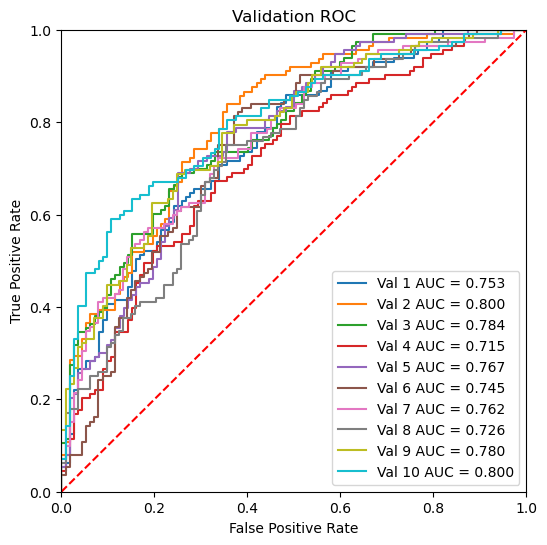

In [68]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

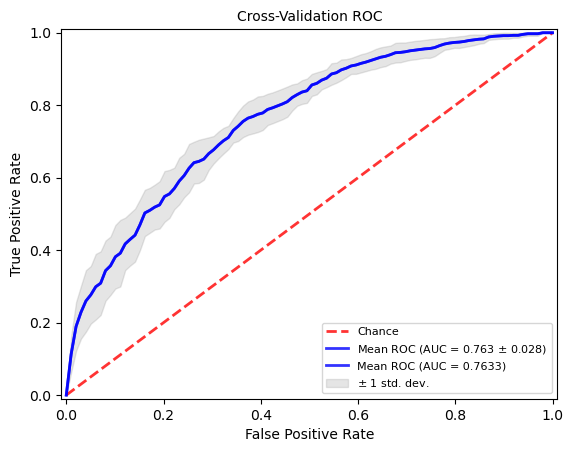

In [69]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [70]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [71]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [72]:
my_calculate_metrics_list_val

[{'SN': 0.7964601769911505,
  'SP': 0.5357142857142857,
  'ACC': 0.6666666666666666,
  'MCC': 0.34421616039687725,
  'Recall': 0.7964601769911505,
  'Precision': 0.6338028169014085,
  'F1-score': 0.7058823529411765,
  'Cutoff': 0.5},
 {'SN': 0.8839285714285714,
  'SP': 0.5803571428571429,
  'ACC': 0.7321428571428571,
  'MCC': 0.4872811533133918,
  'Recall': 0.8839285714285714,
  'Precision': 0.678082191780822,
  'F1-score': 0.7674418604651163,
  'Cutoff': 0.5},
 {'SN': 0.9734513274336283,
  'SP': 0.36607142857142855,
  'ACC': 0.6711111111111111,
  'MCC': 0.4280076140077826,
  'Recall': 0.9734513274336283,
  'Precision': 0.6077348066298343,
  'F1-score': 0.7482993197278912,
  'Cutoff': 0.5},
 {'SN': 0.8230088495575221,
  'SP': 0.4732142857142857,
  'ACC': 0.6488888888888888,
  'MCC': 0.31636176025274765,
  'Recall': 0.8230088495575221,
  'Precision': 0.6118421052631579,
  'F1-score': 0.7018867924528301,
  'Cutoff': 0.5},
 {'SN': 0.8230088495575221,
  'SP': 0.5357142857142857,
  'ACC': 0

In [73]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.796460,0.535714,0.666667,0.344216,0.796460,0.633803,0.705882,0.5
1,0.883929,0.580357,0.732143,0.487281,0.883929,0.678082,0.767442,0.5
2,0.973451,0.366071,0.671111,0.428008,0.973451,0.607735,0.748299,0.5
3,0.823009,0.473214,0.648889,0.316362,0.823009,0.611842,0.701887,0.5
4,0.823009,0.535714,0.680000,0.374696,0.823009,0.641379,0.720930,0.5
5,0.901786,0.477876,0.688889,0.418821,0.901786,0.631250,0.742647,0.5
6,0.687500,0.672566,0.680000,0.360095,0.687500,0.675439,0.681416,0.5
7,0.339286,0.876106,0.608889,0.255478,0.339286,0.730769,0.463415,0.5
8,0.866071,0.495575,0.680000,0.389084,0.866071,0.629870,0.729323,0.5
9,0.669643,0.758929,0.714286,0.430290,0.669643,0.735294,0.700935,0.5


In [74]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.796460,0.535714,0.666667,0.344216,0.796460,0.633803,0.705882,0.5
1,0.883929,0.580357,0.732143,0.487281,0.883929,0.678082,0.767442,0.5
2,0.973451,0.366071,0.671111,0.428008,0.973451,0.607735,0.748299,0.5
3,0.823009,0.473214,0.648889,0.316362,0.823009,0.611842,0.701887,0.5
4,0.823009,0.535714,0.680000,0.374696,0.823009,0.641379,0.720930,0.5
5,0.901786,0.477876,0.688889,0.418821,0.901786,0.631250,0.742647,0.5
6,0.687500,0.672566,0.680000,0.360095,0.687500,0.675439,0.681416,0.5
7,0.339286,0.876106,0.608889,0.255478,0.339286,0.730769,0.463415,0.5
8,0.866071,0.495575,0.680000,0.389084,0.866071,0.629870,0.729323,0.5
9,0.669643,0.758929,0.714286,0.430290,0.669643,0.735294,0.700935,0.5


In [75]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [76]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [77]:
roc_auc_list_indep

[0.7621173469387754,
 0.7753507653061225,
 0.7621970663265306,
 0.787468112244898,
 0.7349330357142857,
 0.7295121173469388,
 0.7667410714285715,
 0.780532525510204,
 0.725845025510204,
 0.7900191326530612]

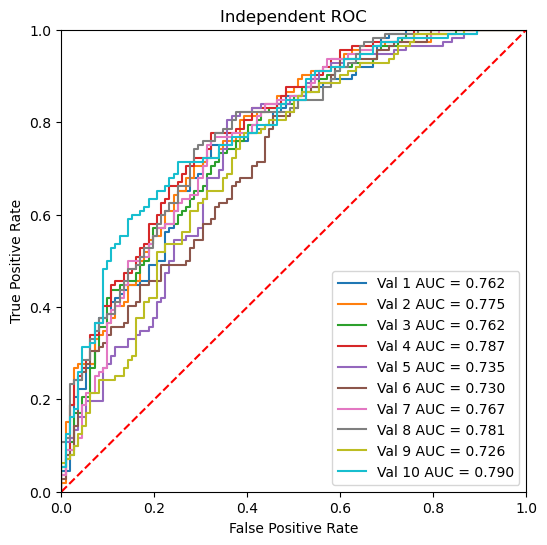

In [78]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

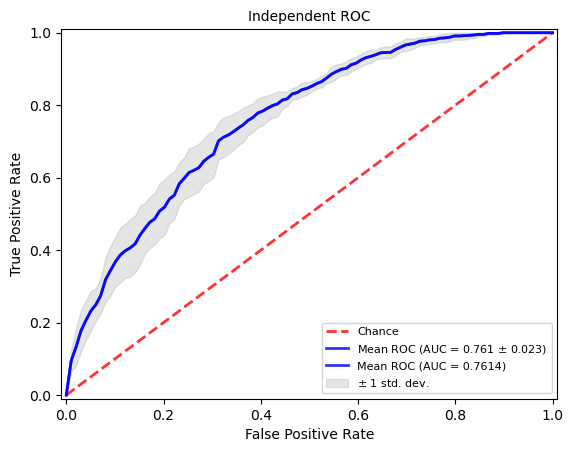

In [79]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [80]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [81]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [82]:
my_calculate_metrics_list_indep

[{'SN': 0.7589285714285714,
  'SP': 0.625,
  'ACC': 0.6919642857142857,
  'MCC': 0.38741883244506226,
  'Recall': 0.7589285714285714,
  'Precision': 0.6692913385826772,
  'F1-score': 0.7112970711297071,
  'Cutoff': 0.5},
 {'SN': 0.8214285714285714,
  'SP': 0.5625,
  'ACC': 0.6919642857142857,
  'MCC': 0.39748418438347904,
  'Recall': 0.8214285714285714,
  'Precision': 0.6524822695035462,
  'F1-score': 0.7272727272727273,
  'Cutoff': 0.5},
 {'SN': 0.9285714285714286,
  'SP': 0.35714285714285715,
  'ACC': 0.6428571428571429,
  'MCC': 0.3481553119113957,
  'Recall': 0.9285714285714286,
  'Precision': 0.5909090909090909,
  'F1-score': 0.7222222222222222,
  'Cutoff': 0.5},
 {'SN': 0.8392857142857143,
  'SP': 0.5267857142857143,
  'ACC': 0.6830357142857143,
  'MCC': 0.38537170704786466,
  'Recall': 0.8392857142857143,
  'Precision': 0.6394557823129252,
  'F1-score': 0.7258687258687259,
  'Cutoff': 0.5},
 {'SN': 0.8392857142857143,
  'SP': 0.5178571428571429,
  'ACC': 0.6785714285714286,
  'M

In [83]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.758929,0.625000,0.691964,0.387419,0.758929,0.669291,0.711297,0.5
1,0.821429,0.562500,0.691964,0.397484,0.821429,0.652482,0.727273,0.5
2,0.928571,0.357143,0.642857,0.348155,0.928571,0.590909,0.722222,0.5
3,0.839286,0.526786,0.683036,0.385372,0.839286,0.639456,0.725869,0.5
4,0.839286,0.517857,0.678571,0.377157,0.839286,0.635135,0.723077,0.5
5,0.937500,0.392857,0.665179,0.393907,0.937500,0.606936,0.736842,0.5
6,0.660714,0.705357,0.683036,0.366437,0.660714,0.691589,0.675799,0.5
7,0.348214,0.928571,0.638393,0.339880,0.348214,0.829787,0.490566,0.5
8,0.803571,0.553571,0.678571,0.368856,0.803571,0.642857,0.714286,0.5
9,0.607143,0.821429,0.714286,0.438763,0.607143,0.772727,0.680000,0.5


In [84]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.758929,0.625000,0.691964,0.387419,0.758929,0.669291,0.711297,0.5
1,0.821429,0.562500,0.691964,0.397484,0.821429,0.652482,0.727273,0.5
2,0.928571,0.357143,0.642857,0.348155,0.928571,0.590909,0.722222,0.5
3,0.839286,0.526786,0.683036,0.385372,0.839286,0.639456,0.725869,0.5
4,0.839286,0.517857,0.678571,0.377157,0.839286,0.635135,0.723077,0.5
5,0.937500,0.392857,0.665179,0.393907,0.937500,0.606936,0.736842,0.5
6,0.660714,0.705357,0.683036,0.366437,0.660714,0.691589,0.675799,0.5
7,0.348214,0.928571,0.638393,0.339880,0.348214,0.829787,0.490566,0.5
8,0.803571,0.553571,0.678571,0.368856,0.803571,0.642857,0.714286,0.5
9,0.607143,0.821429,0.714286,0.438763,0.607143,0.772727,0.680000,0.5


In [85]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_AcetdelUbi\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

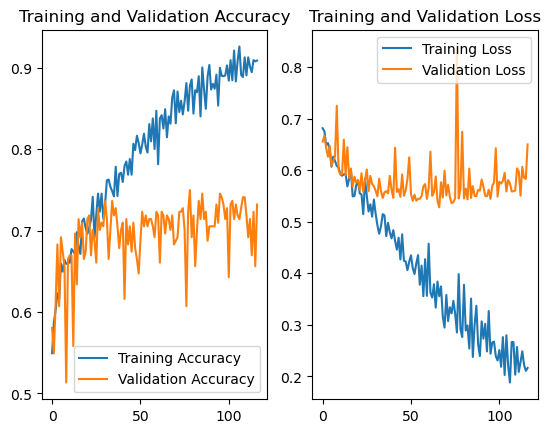

In [87]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()